In [33]:
import numpy as np
import matplotlib.pyplot as plt
import zetapy as zt
import timewizard.perievent as tw
import timewizard.util as twu

In [2]:
%load_ext autoreload
%autoreload 2

# Generate some fake data

In [30]:
fs = 100
total_time = 1000  # seconds
n_events = 10
t = np.arange(0,total_time, 1/fs)  # sampled at 100 Hz
y = np.zeros(t.shape) + 0.5 * np.random.normal(size=t.shape)
event_times = np.random.random(size=n_events) * total_time
event_template = np.arange(10,0,-0.1)
event_len = len(event_template)
for evt in event_times:
    start_idx = tw.index_of_nearest_value(t, [evt], force_side="right")[0]
    y[start_idx:(start_idx + event_len)] += event_template

(array([  0, 100, 200, 300]), array([-2., -1.,  0.,  1.]))

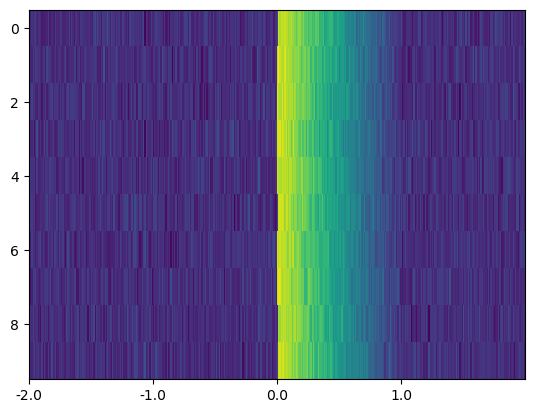

In [34]:
ts, traces = tw.perievent_traces(t, y, event_times, (-2,2), fs=fs)
plt.imshow(traces, aspect='auto', interpolation='none')
twu.xticks_from_timestamps(ts)

# Run zetapy

In [183]:
p, stats = zt.zetatstest(t, y, event_times, dblUseMaxDur=1, fs=fs)

> /Users/jonahpearl/Documents/PiN/Datta_lab/Local_code/zetapy/zetapy/ts_dependencies.py(311)calcTsZetaOne()
    309     # Get the aligned peri-event data, interpolating if necessary
    310     pdb.set_trace()
--> 311     vecAlignedTimestamps, matAlignedTraces = _collate_events(vecTimestamps, vecData, vecEventT, dblUseMaxDur, fs=fs)
    312 
    313 



ipdb>  c


In [184]:
p

0.3497057324596323

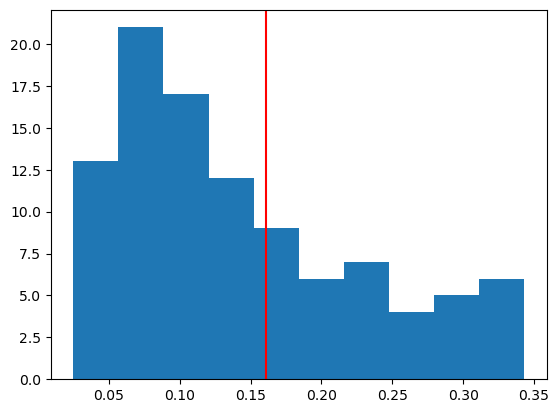

In [190]:
plt.hist(stats['vecMaxRandD'])
plt.axvline(stats['dblMaxD'], color='r')

In [43]:
stats.keys()

dict_keys(['dblZetaP', 'dblZETA', 'dblMeanZ', 'dblMeanP', 'dblZETADeviation', 'dblLatencyZETA', 'intZETAIdx', 'vecMu_Dur', 'vecMu_Base', 'dblD_InvSign', 'dblLatencyInvZETA', 'intIdx_InvSign', 'vecRealTime', 'vecRealDeviation', 'vecRealFrac', 'vecRealFracLinear', 'cellRandTime', 'cellRandDeviation', 'dblUseMaxDur'])

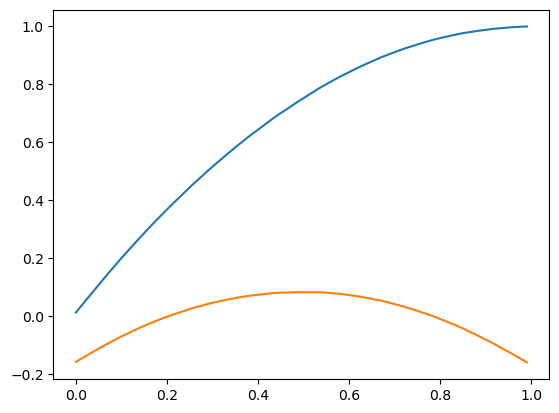

In [173]:
plt.plot(stats['vecRealTime'], stats['vecRealFrac'])
plt.plot(stats['vecRealTime'], stats['vecRealDeviation'])

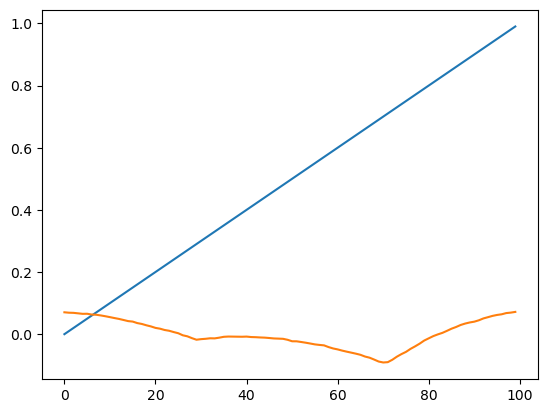

In [174]:
plt.plot(stats['cellRandTime'][0])
plt.plot(stats['cellRandDeviation'][0])

# Investigate its innards

## Psueotime series

In [54]:
vecPseudoT, vecPseudoV, vecPseudoEventT = zt.ts_dependencies.getPseudoTimeSeries(t, y, event_times, 1)

In [72]:
event_times

array([100.17237044, 189.74880451, 328.07820994, 882.77508568,
       124.72806171, 294.26144186, 791.22787415, 603.99963897,
       851.4720684 , 302.99311384])

In [70]:
vecPseudoT.max()

226.39000000000004

In [73]:
vecPseudoEventT

array([[100.17237044],
       [101.17806171],
       [102.17880451],
       [103.17144186],
       [104.17311384],
       [105.17820994],
       [106.17963897],
       [107.17787415],
       [108.1720684 ],
       [109.17508568]])

(99.0, 110.0)

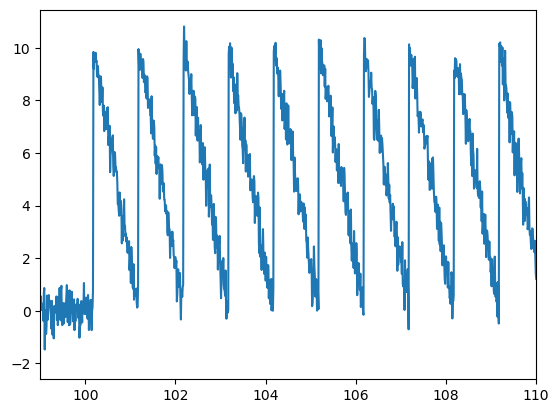

In [125]:
plt.plot(vecPseudoT, vecPseudoV)
plt.xlim([99,110])

In [77]:
vecRealDeviation, vecRealFrac, vecRealFracLinear, vecRealTime  = zt.ts_dependencies.getTimeseriesOffsetOne(
    vecPseudoT, 
    vecPseudoV, 
    vecPseudoEventT, 
    1
)

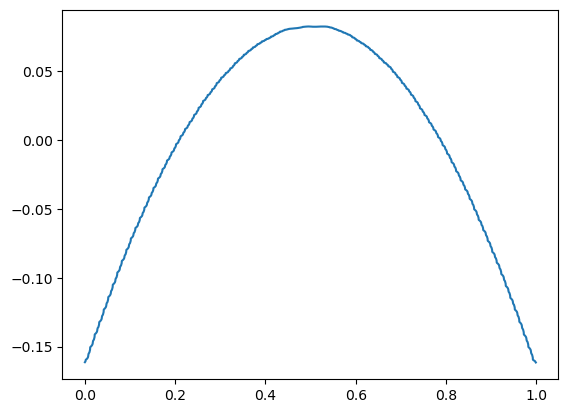

In [79]:
plt.plot(vecRealTime, vecRealDeviation)

## Recreate getTimeseriesOffsetOne

In [129]:
# vecPseudoT, vecPseudoV, vecPseudoEventT, dblUseMaxDur
dblUseMaxDur = 1

# prepare
vecTime = zt.ts_dependencies.getTsRefT(vecPseudoT, vecPseudoEventT, dblUseMaxDur)

# build interpolated data
vecTime, matTracePerTrial = zt.ts_dependencies.getInterpolatedTimeSeries(vecPseudoT, vecPseudoV, vecPseudoEventT, vecTime)
indKeepPoints = np.logical_and(vecTime >= 0, vecTime <= dblUseMaxDur)
vecTime = vecTime[indKeepPoints]
matTracePerTrial = matTracePerTrial[:, indKeepPoints]
vecMeanTrace = np.nanmean(matTracePerTrial, axis=0)
vecThisFrac = np.cumsum(vecMeanTrace) / np.sum(vecMeanTrace)

# get linear fractions
vecThisFracLinear = np.linspace(np.mean(vecMeanTrace), np.sum(
    vecMeanTrace), len(vecMeanTrace)) / np.sum(vecMeanTrace)

# assign data
vecDeviation = vecThisFrac - vecThisFracLinear
vecDeviation = vecDeviation - np.mean(vecDeviation)

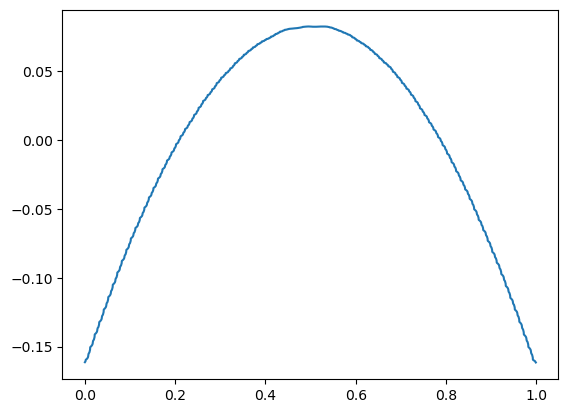

In [130]:
plt.plot(vecTime, vecDeviation)

In [131]:
# recreate with tw -
# nb getTsRefT has upsampled everything lol.
vecTime, matTracePerTrial = tw.perievent_traces(t, y, event_times, (0,1), fs=fs)
indKeepPoints = np.logical_and(vecTime >= 0, vecTime <= dblUseMaxDur)
vecTime = vecTime[indKeepPoints]
matTracePerTrial = matTracePerTrial[:, indKeepPoints]
vecMeanTrace = np.nanmean(matTracePerTrial, axis=0)
vecThisFrac = np.cumsum(vecMeanTrace) / np.sum(vecMeanTrace)

# get linear fractions
vecThisFracLinear = np.linspace(np.mean(vecMeanTrace), np.sum(
    vecMeanTrace), len(vecMeanTrace)) / np.sum(vecMeanTrace)

# assign data
vecDeviation = vecThisFrac - vecThisFracLinear
vecDeviation = vecDeviation - np.mean(vecDeviation)

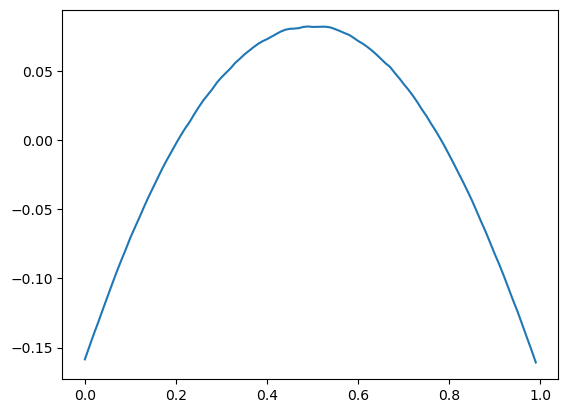

In [132]:
plt.plot(vecTime, vecDeviation)

## Look at getTsRefT
Problem is you're doing floating point subtraction and then trying to keep some set of unique timestamps..? very odd

In [118]:
vecTimestamps = vecPseudoT
vecEventStartT = vecPseudoEventT
dblUseMaxDur = 1

# pre-allocate
vecEventStartT = np.sort(vecEventStartT)
intTimeNum = len(vecTimestamps)-1

# intTrial = -1
# build common timeframe
cellRefT = []
for intTrial, dblStartT in enumerate(vecEventStartT):
    
    intBegin = zt.ts_dependencies.findfirst(vecTimestamps > dblStartT)
    if intBegin is None:
        intStartT = 0
    else:
        intStartT = np.max([0, intBegin - 1])

    dblStopT = dblStartT+dblUseMaxDur
    intEnd = zt.ts_dependencies.findfirst(vecTimestamps > dblStopT)
    if intEnd is None:
        intStopT = intTimeNum
    else:
        intStopT = np.min([intTimeNum, intEnd])

    vecSelectSamples = np.arange(intStartT, intStopT+1)

    # save data
    cellRefT.append(vecTimestamps[vecSelectSamples]-dblStartT)
    
# set tol
dblSampInterval = np.median(np.diff(vecTimestamps, axis=0))
dblTol = dblSampInterval/100
vecVals = np.sort(np.vstack(np.concatenate(cellRefT)))
vecTime = np.hstack(zt.ts_dependencies.uniquetol(vecVals, dblTol))

# return
# return vecTime

## Investigate jitters

In [140]:
# create random jitters
intResampNum = 100
dblJitterSize = 2
dblUseMaxDur = 1

# run pre-set number of iterations
cellRandTime = []
cellRandDeviation = []
vecMaxRandD = np.empty((intResampNum, 1))
vecMaxRandD.fill(np.nan)

vecStartOnly = np.reshape(vecPseudoEventT, (-1, 1))
intTrials = vecStartOnly.size
matJitterPerTrial = np.empty((intTrials, intResampNum))
matJitterPerTrial.fill(np.nan)
# uniform jitters between dblJitterSize*[-tau, +tau]
for intResampling in range(intResampNum):
    matJitterPerTrial[:, intResampling] = dblJitterSize*dblUseMaxDur * \
        ((np.random.rand(vecStartOnly.shape[0]) - 0.5) * 2)
    

In [146]:
vecStimUseOnTime = vecStartOnly[:, 0] + matJitterPerTrial[:, intResampling].T
# get temp offset
vecRandDeviation, vecThisFrac, vecThisFracLinear, vecRandT = zt.ts_dependencies.getTimeseriesOffsetOne(
    vecPseudoT, vecPseudoV, vecStimUseOnTime, dblUseMaxDur)

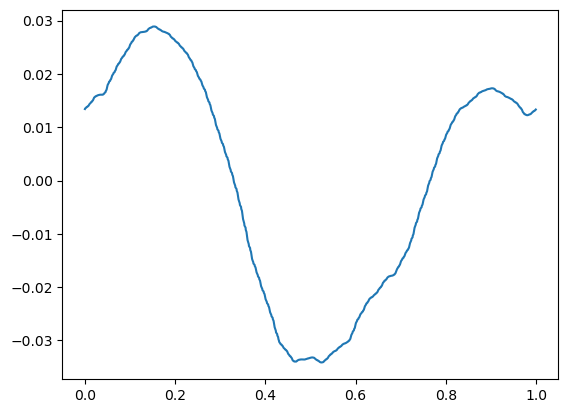

In [147]:
plt.plot(vecRandT, vecRandDeviation)

In [156]:
# recreate with tw -
event_times_jittered = event_times + matJitterPerTrial[:, intResampling].T
vecTime, matTracePerTrial = tw.perievent_traces(t, y, event_times_jittered, (0,1), fs=fs)
indKeepPoints = np.logical_and(vecTime >= 0, vecTime <= dblUseMaxDur)
vecTime = vecTime[indKeepPoints]
matTracePerTrial = matTracePerTrial[:, indKeepPoints]
vecMeanTrace = np.nanmean(matTracePerTrial, axis=0)
vecThisFrac = np.cumsum(vecMeanTrace) / np.sum(vecMeanTrace)

# get linear fractions
vecThisFracLinear = np.linspace(np.mean(vecMeanTrace), np.sum(
    vecMeanTrace), len(vecMeanTrace)) / np.sum(vecMeanTrace)

# assign data
vecDeviation = vecThisFrac - vecThisFracLinear
vecDeviation = vecDeviation - np.mean(vecDeviation)

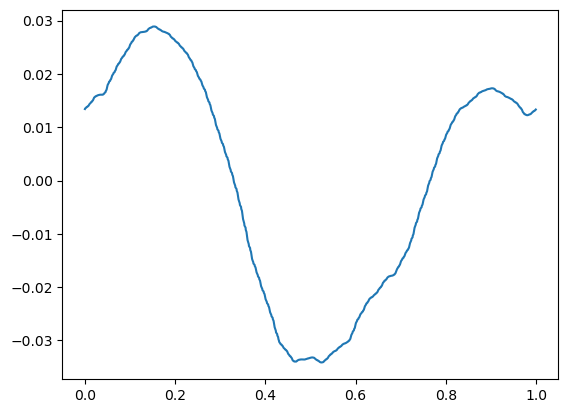

In [157]:
plt.plot(vecRandT, vecRandDeviation)